In [121]:
import json
import numpy as np
from scipy.misc import imread, imresize
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable

In [203]:
# Data Loading
class IndianClothingDataset(Dataset):
    '''Indian Clothing Dataset'''
    def __init__(self, json_file, transform=None, split_type=None):
        """
        Args:
            json_file (string): Path to the json file
            transform (callable): Optional transform to apply to sample
            split_type (string): train or val or test
        """
        
        labels_map = {'men>topwear>casual>casualshirts': 0,
                     'men>topwear>casual>sweatshirtshoodies': 1,
                     'men>topwear>formal>blazers': 2}
    
        with open(json_file, 'r') as j:
            data = json.load(j)
        X=[]
        Y=[]
        for product in data['images']:
            if product['split'] == split_type:
                taxonomy = '>'.join(product['sentences'][0]['tokens'])
                taxonomy = labels_map[taxonomy]
                image_path = "../datasets/toy_dataset/" + product['filename']
                img = imread(image_path)
                img = imresize(img, (224, 224))
                img = img.transpose(2, 0, 1)
                X.append(img)
                Y.append(taxonomy)
        
        self.data = np.array(X)
        self.targets = Y
        self.transform = transform;
            
    def __len__(self):
        return len(self.data);
    
    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], self.targets[index]

        return img, target

In [204]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [205]:
train_dataset = IndianClothingDataset(json_file='../datasets/toy_dataset/indian_clothing_with_title_toy.json',split_type='train', transform=data_transforms['train']);
test_dataset = IndianClothingDataset(json_file='../datasets/toy_dataset/indian_clothing_with_title_toy.json',split_type='test', transform=data_transforms['test'])

/home/sosilee/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/sosilee/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


In [206]:
image, label = train_dataset.__getitem__(1)
image.shape

(3, 224, 224)

In [207]:
# declare the essential hyperparameters
num_epochs = 5;
batch_size = 2;
learning_rate = 0.001;

In [208]:
# define the data loaders using the DataLoader module
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True);
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=True);

In [209]:
# train data size for first batch
image, labels = next(iter(train_loader))
image.shape

torch.Size([2, 3, 224, 224])

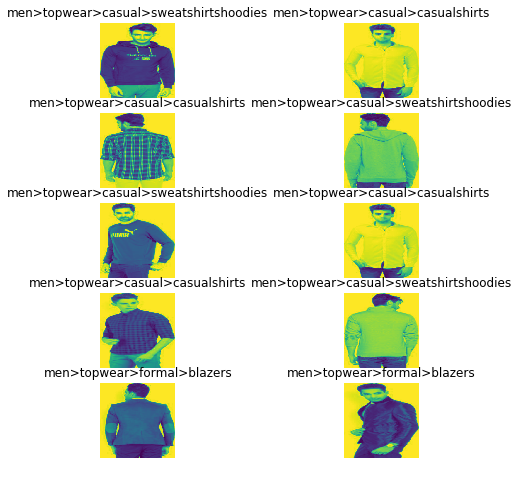

In [123]:
# using the data reader to visualize some images and see the dataset
labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt',
              7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'};
fig = plt.figure(figsize=(8,8));
columns = 2;
rows = 5;
for i in range(1, columns*rows +1):
    img_xy = np.random.randint(len(train_dataset));
    img = train_dataset[img_xy][0][0,:,:]
    fig.add_subplot(rows, columns, i)
    plt.title(train_dataset[img_xy][1])
    plt.axis('off')
    plt.imshow(img)
plt.show()

In [168]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 3)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [187]:
# model training
losses = [];
for epoch in range(num_epochs):
    exp_lr_scheduler.step()
    model_conv.train()
     
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images.float())
        labels = Variable(labels)
        images = images.to(device)
        labels = labels.to(device)

        # Forward + Backward + Optimize
        optimizer_conv.zero_grad()
        outputs = model_conv(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_conv.step()
        
        losses.append(loss.data[0]);
        
        if (i+1) % 10 == 0:
            print ('Epoch : %d/%d, Iter : %d/%d,  Loss: %.4f' 
                   %(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.data[0]))

/home/sosilee/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/sosilee/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch : 1/5, Iter : 10/82,  Loss: 0.8974
Epoch : 1/5, Iter : 20/82,  Loss: 0.2935
Epoch : 1/5, Iter : 30/82,  Loss: 0.4475
Epoch : 1/5, Iter : 40/82,  Loss: 0.5329
Epoch : 1/5, Iter : 50/82,  Loss: 0.6871
Epoch : 1/5, Iter : 60/82,  Loss: 0.8754
Epoch : 1/5, Iter : 70/82,  Loss: 0.2965
Epoch : 1/5, Iter : 80/82,  Loss: 0.5661
Epoch : 2/5, Iter : 10/82,  Loss: 2.6823
Epoch : 2/5, Iter : 20/82,  Loss: 1.5929
Epoch : 2/5, Iter : 30/82,  Loss: 0.9308
Epoch : 2/5, Iter : 40/82,  Loss: 0.1348
Epoch : 2/5, Iter : 50/82,  Loss: 0.8811
Epoch : 2/5, Iter : 60/82,  Loss: 0.4616
Epoch : 2/5, Iter : 70/82,  Loss: 0.2337
Epoch : 2/5, Iter : 80/82,  Loss: 2.4864
Epoch : 3/5, Iter : 10/82,  Loss: 4.0995
Epoch : 3/5, Iter : 20/82,  Loss: 0.4060
Epoch : 3/5, Iter : 30/82,  Loss: 1.5918
Epoch : 3/5, Iter : 40/82,  Loss: 0.3790
Epoch : 3/5, Iter : 50/82,  Loss: 0.2462
Epoch : 3/5, Iter : 60/82,  Loss: 1.1002
Epoch : 3/5, Iter : 70/82,  Loss: 0.2052
Epoch : 3/5, Iter : 80/82,  Loss: 0.4953
Epoch : 4/5, Ite

In [202]:
# Evaluating the model
model_conv.eval()
correct = 0
total = 0
for i, (images, labels) in enumerate(test_loader):
    images = Variable(images.float())
    images = images.to(device)
    labels = labels.to(device)
    outputs = model_conv(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
print('Test Accuracy of the model on the %d test images: %.4f %%' % (test_loader.dataset.__len__(),100 * correct / total))

Test Accuracy of the model on the 87 test images: 67.0000 %
